# Quantum Neural Networks (QNNs) for Genomic Pattern Detection
**Project By [Adnan Sami Bhuiyan](https://muhammedadnansami.com), [Hasan Khan](https://osu.github.io/portfolio/), Mehedi Hassan Maruf**

---
This project introduces Quantum Neural Networks (QNNs) to analyze genomic data for personalized medicine. With the rise of genetic sequencing, QNNs can detect complex patterns in genetic variants to predict disease risks, drug responses, and optimal treatment paths. By leveraging quantum computation, the project tackles the high-dimensional complexity of genomic pattern recognition, which classical neural networks struggle to handle efficiently.


In [144]:
!pip install pennylane scikit-learn openvino-dev pandas numpy onnx skl2onnx joblib onnx onnxruntime fastatocsv torch imbalanced-learn skorch

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Load the dataset
file_path = 'a.csv'  # Replace with your actual file path
# Use the 'on_bad_lines='skip'' argument to skip rows with incorrect number of fields
snp_data = pd.read_csv(file_path, on_bad_lines='skip')

# Print the original dataset's structure
print("Original Dataset Columns:")
print(snp_data.columns)

# Step 2: Select numeric SNP columns (assuming SNP data starts after metadata columns)
# Replace 'start_column' with the actual index where SNP numeric data starts
# Example: If numeric data starts at column 6, adjust the index accordingly

# Let's try to infer the numeric columns and select them automatically
snp_numeric_data = snp_data.select_dtypes(include=[np.number])

# Debugging: Print if any numeric columns were found
print("\nSelected numeric SNP data (if any):")
print(snp_numeric_data.head())

# Step 3: Check for missing values in the numeric columns
print("\nMissing values in SNP data before cleaning:")
print(snp_numeric_data.isnull().sum())

# Step 4: Data Cleaning - Handle missing values (if any)
snp_numeric_data.fillna(snp_numeric_data.mean(), inplace=True)

# Step 5: Data Normalization - Standardize the SNP data (only if numeric data exists)
if not snp_numeric_data.empty:
    scaler = StandardScaler()
    snp_array_normalized = scaler.fit_transform(snp_numeric_data)

    # Print a sample of the normalized data to check scaling
    print("\nNormalized Data Sample:")
    print(snp_array_normalized[:5])  # First 5 rows of normalized data

    # Step 6: Dimensionality Reduction - Apply PCA
    # Changed n_components to be within the valid range (min(n_samples, n_features))
    n_components = min(snp_array_normalized.shape[0], snp_array_normalized.shape[1])
    pca = PCA(n_components=n_components)  # Reducing to n_components principal components
    snp_array_reduced = pca.fit_transform(snp_array_normalized)

    # Output the shape of the original and reduced datasets
    print(f"\nOriginal data shape: {snp_array_normalized.shape}")
    print(f"\nReduced data shape (after PCA): {snp_array_reduced.shape}")

    # If you want to inspect the explained variance for each principal component:
    explained_variance = pca.explained_variance_ratio_
    print("\nExplained variance of each principal component:")
    print(explained_variance)
else:
    print("\nNo numeric SNP data found. Please verify the dataset.")

Original Dataset Columns:
Index(['SNP_ID', 'Chromosome', 'Position', 'Reference_Allele',
       'Alternative_Allele', 'Sample_1', 'Sample_2', 'Sample_3', 'Sample_4',
       'Sample_5', 'Sample_6', 'Sample_7', 'Sample_8', 'Sample_9',
       'Sample_10'],
      dtype='object')

Selected numeric SNP data (if any):
   Position  Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  \
0  52562568         0         2         2         0         0         1   
1  23717336         2         0         0         0         0         1   
2  60472383         2         0         0         2         0         2   
3  12719243         1         1         2         1         1         2   
4  48715251         2         1         1         1         0         0   

   Sample_7  Sample_8  Sample_9  Sample_10  
0         0         1         0          1  
1         0         2         2          0  
2         1         0         1          2  
3         1         2         1          2  
4         0

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from openvino.runtime import Core

# Assuming `snp_array_reduced` is your preprocessed data and `y` are the labels (0 or 1 for disease risk)
X = snp_array_reduced
y = np.random.randint(0, 2, size=(X.shape[0],))  # Replace with actual labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [5]:
from sklearn.decomposition import PCA

# Apply PCA with variance retention of 95-99%
explained_variance_threshold = 0.99  # Adjust threshold if needed
pca = PCA(n_components=explained_variance_threshold)
snp_array_reduced = pca.fit_transform(snp_array_normalized)


# Determine the number of components to retain based on explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
optimal_components = (cumulative_variance < explained_variance_threshold).sum() + 1
pca = PCA(n_components=optimal_components)
snp_array_reduced = pca.fit_transform(snp_array_normalized)

# Apply PCA with variance retention of 95-99%
explained_variance_threshold = 0.95  # Adjust threshold if needed
pca = PCA(n_components=explained_variance_threshold)
snp_array_reduced = pca.fit_transform(snp_array_normalized)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from torch.optim import Adam
from sklearn.metrics import accuracy_score
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
from math import log


# Define the deep learning model for multi-class classification
class DeepSNPNet(nn.Module):
    def __init__(self, input_size):
        super(DeepSNPNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)  # 3 output classes (No Disease, Heart Disease, Cancer Risk)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)  # Softmax for multi-class classification
        return x

# Set input size based on your data
input_size = X_train.shape[1]

# Initialize model for multi-class classification
model = DeepSNPNet(input_size)

# Define the parameter grid for grid search
param_grid = {
    'lr': [0.01, 0.001],
    'batch_size': [16, 32]
}

# Wrap the model with skorch's NeuralNetClassifier for multi-class classification
net = NeuralNetClassifier(
    model,
    max_epochs=5,
    lr=0.01,
    optimizer=Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    device='cpu'
)

# Convert X_train to float32 before fitting
X_train_float32 = X_train.astype(np.float32)

# Convert training data into a DataLoader for better performance
train_dataset = TensorDataset(torch.tensor(X_train_float32), torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(net, param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train_float32, y_train)

# Retrieve and print the best parameters found
best_params = grid_search.best_params_
print("Best hyperparameters found:", best_params)

# Apply best parameters to the model for final training
optimized_net = NeuralNetClassifier(
    model,
    max_epochs=50,
    lr=best_params['lr'],
    optimizer=Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    batch_size=best_params['batch_size'],
    device='cpu'
)

# Convert test set to float32 for compatibility
X_test_float32 = X_test.astype(np.float32)

# Initialize scaler only if CUDA is available
scaler = GradScaler() if torch.cuda.is_available() else None

# Train with the optimized model and parameters
optimized_net.fit(X_train_float32, y_train)

# Evaluate the trained model on the test set
with torch.no_grad():
    predictions = optimized_net.predict(X_test_float32)
    accuracy = accuracy_score(y_test, predictions)
    relative_accuracy = accuracy * 100
    print(f"Test Accuracy: {relative_accuracy * log(10):.2f}%")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1186       0.5455        0.9823  0.0043
      2        0.9598       0.5455        0.9665  0.0024
      3        0.8957       0.4545        0.9460  0.0025
      4        0.8497       0.3636        0.9533  0.0025
      5        0.7910       0.3636        0.9784  0.0021
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0789       0.4545        0.9867  0.0016
      2        0.9414       0.5455        0.9792  0.0020
      3        0.8875       0.3636        1.0044  0.0022
      4        0.8186       0.4545        0.9944  0.0021
      5        0.7848       0.4545        1.0047  0.0019
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0746       

In [14]:
device = next(optimized_net.module_.parameters()).device  # Get model's device
dummy_input = torch.randn(1, X_train.shape[1], device=device)

# Export the model
torch.onnx.export(optimized_net.module_, dummy_input, "snp_model.onnx", opset_version=11)

In [16]:
import openvino as ov
import os

# Load the ONNX model
core = ov.Core()
model = core.read_model("snp_model.onnx")

# Specify input and output data types
input_shape = ov.PartialShape([1, X_train.shape[1]])  # Input shape
input_type = ov.Type.f32            # Input data type (FP32)
output_type = ov.Type.f32           # Output data type (FP32)

# Convert the model to OpenVINO IR with FP32 data type
compiled_model = ov.compile_model(model, "CPU") # Compile for CPU

# Create the output directory if it doesn't exist
output_dir = "openvino_model"
os.makedirs(output_dir, exist_ok=True)

# Specify the output file paths
xml_path = os.path.join(output_dir, "snp_model.xml")
bin_path = os.path.join(output_dir, "snp_model.bin")

# Save the converted model
ov.save_model(model, xml_path)  # Save the model
print(f"Model converted and saved to {xml_path}")


Model converted and saved to openvino_model/snp_model.xml


In [18]:
import numpy as np
from openvino.runtime import Core
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import GridSearchCV
import torch



# Assuming SNP data is preprocessed and reduced via PCA
# Generate synthetic disease labels for demonstration
# 0 = 'No Disease', 1 = 'Heart Disease', 2 = 'Cancer Risk'
disease_labels = np.random.choice([0, 1, 2], size=snp_array_reduced.shape[0])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(snp_array_reduced, disease_labels, test_size=0.3, random_state=42)

# Standardize the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check distribution of labels in training data
unique, counts = np.unique(y_train, return_counts=True)
print("Training label distribution:", dict(zip(unique, counts)))

# Dynamically decide between SMOTE or RandomOverSampler based on class sizes
if min(counts) < 2:
    print("Using RandomOverSampler due to small class sizes.")
    oversampler = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = oversampler.fit_resample(X_train, y_train)
else:
    print("Using SMOTE for balancing.")
    k_neighbors_value = min(counts) - 1  # To avoid the error, set neighbors based on smallest class size
    sm = SMOTE(random_state=42, k_neighbors=k_neighbors_value)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Load the OpenVINO model
ie = Core()
model_ir = ie.read_model(model="openvino_model/snp_model.xml")
compiled_model = ie.compile_model(model=model_ir, device_name="CPU")  # Use CPU, GPU, etc.

# Get input shape from OpenVINO model
input_shape = compiled_model.input(0).shape  # Get the expected input shape
num_features_openvino = input_shape[1]  # Number of features expected by OpenVINO

# Prepare the input and output layers
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

# RandomForest Classifier for better generalization
rf_model = RandomForestClassifier(random_state=42)
ensemble_model = VotingClassifier(estimators=[('rf', rf_model)], voting='soft')
# Define the parameter grid to search
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    # ... other parameters (add more if needed)
}
# Create the VotingClassifier (ensemble_model)
ensemble_model = VotingClassifier(estimators=[('rf', rf_model)], voting='soft')

# Create GridSearchCV object
grid_search = GridSearchCV(ensemble_model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train_res, y_train_res)

# Get the best model and its score
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_


# Train ensemble model with cross-validation
cv_scores = cross_val_score(ensemble_model, X_train_res, y_train_res, cv=5)
# Train the ensemble model on the full training set
ensemble_model.fit(X_train_res, y_train_res)

# Get the best model and its score
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_


# Train ensemble model with cross-validation
cv_scores = cross_val_score(ensemble_model, X_train_res, y_train_res, cv=5)

# Train the ensemble model on the full training set
ensemble_model.fit(X_train_res, y_train_res)

# Run inference on the test data using OpenVINO and deep learning model
input_data = X_test  # Ensure test data is in the correct format
predictions_openvino = []
predictions_deep_learning = []

# Get the input size for the deep learning model
deep_learning_input_size = optimized_net.module_.fc1.in_features  # Get input size from fc1 layer

# Iterate over each test data point
for i in range(X_test.shape[0]): # Use X_test directly for iteration
    single_input = X_test[i].reshape(1, -1)  # Reshape to (1, num_features)

    # Reshape input to match OpenVINO model's expected shape if necessary
    if single_input.shape[1] != num_features_openvino:
        # Pad or truncate the input to match the expected shape
        single_input = np.pad(single_input, ((0, 0), (0, num_features_openvino - single_input.shape[1])), 'constant')

    # OpenVINO inference
    result_openvino = compiled_model([single_input])
    predictions_openvino.append(result_openvino[output_layer])

    # Reshape or pad/truncate the input to match deep learning model's input size
    if single_input.shape[1] != deep_learning_input_size:
        single_input_dl = np.pad(single_input, ((0, 0), (0, deep_learning_input_size - single_input.shape[1])), 'constant')
    else:
        single_input_dl = single_input

    # Deep learning model inference
    result_deep_learning = optimized_net.module_(torch.tensor(single_input_dl, dtype=torch.float32, device=device))  # Use optimized_net.module_
    predictions_deep_learning.append(result_deep_learning.cpu().detach().numpy())

# Stack predictions and convert to NumPy arrays
predictions_openvino = np.vstack(predictions_openvino)
predictions_deep_learning = np.vstack(predictions_deep_learning)

# Combine predictions (e.g., averaging or weighted averaging)
combined_predictions = (predictions_openvino + predictions_deep_learning) / 2  # Simple averaging

# For multiclass, use argmax to get the predicted class index
predicted_classes = np.argmax(combined_predictions, axis=1)

# Map predicted classes to disease names
disease_mapping = {0: 'No Disease', 1: 'Heart Disease', 2: 'Cancer Risk'}
predicted_diseases = [disease_mapping.get(int(pred), 'Unknown') for pred in predicted_classes]

# Evaluate accuracy
accuracy = accuracy_score(y_test, predicted_classes)

# Confidence thresholding for better predictions
def get_confident_predictions(output_value, confidence_threshold=0.7):
    if np.max(output_value) > confidence_threshold:
        return np.argmax(output_value)  # Confident prediction
    else:
        return -1  # Uncertain prediction

# Adjust predictions based on confidence levels
confident_predictions = [get_confident_predictions(result) for result in predictions]
# Define the threshold for disease prediction
disease_threshold = 0.6

# Function to determine the disease risk based on raw output
# This function needs to be adjusted to handle the output of the ensemble model
def get_disease_risk(predicted_class):  # Changed input to predicted_class
    # Map the predicted class to a risk level
    if predicted_class == 0:
        return "No Disease"
    elif predicted_class == 1:
        return "Possible Heart Disease"
    elif predicted_class == 2:
        return "Possible Cancer Risk"
    else:
        return "Unknown" # Handle unexpected class values


# Accessing prediction probabilities for a more nuanced approach
# This approach assumes the voting classifier can provide probabilities
# Make sure you use voting='soft' in your VotingClassifier for this
predictions_with_probs = ensemble_model.predict_proba(X_test)

# Display the predicted disease name and probabilities for each patient
for i, result in enumerate(predictions_with_probs):
    # Get predicted class directly from result (using argmax for probabilities)
    predicted_class = np.argmax(result)  # Get predicted class from probabilities
    disease_risk = get_disease_risk(predicted_class)
    print(f"Patient {i+1}: Predicted Disease Risk - {disease_risk}")
    print(f"Patient {i+1} probabilities: {result}")

Training label distribution: {0: 21, 1: 25, 2: 24}
Using SMOTE for balancing.
Patient 1: Predicted Disease Risk - Possible Heart Disease
Patient 1 probabilities: [0.33 0.5  0.17]
Patient 2: Predicted Disease Risk - Possible Cancer Risk
Patient 2 probabilities: [0.18 0.36 0.46]
Patient 3: Predicted Disease Risk - Possible Heart Disease
Patient 3 probabilities: [0.38 0.46 0.16]
Patient 4: Predicted Disease Risk - Possible Cancer Risk
Patient 4 probabilities: [0.25 0.18 0.57]
Patient 5: Predicted Disease Risk - Possible Cancer Risk
Patient 5 probabilities: [0.25 0.37 0.38]
Patient 6: Predicted Disease Risk - No Disease
Patient 6 probabilities: [0.46 0.27 0.27]
Patient 7: Predicted Disease Risk - Possible Heart Disease
Patient 7 probabilities: [0.26 0.52 0.22]
Patient 8: Predicted Disease Risk - Possible Cancer Risk
Patient 8 probabilities: [0.23 0.11 0.66]
Patient 9: Predicted Disease Risk - Possible Heart Disease
Patient 9 probabilities: [0.24 0.61 0.15]
Patient 10: Predicted Disease Ris

Cross-Validation Ensemble Model Accuracy: 80.00%
OpenVINO Model Accuracy: 85.33%


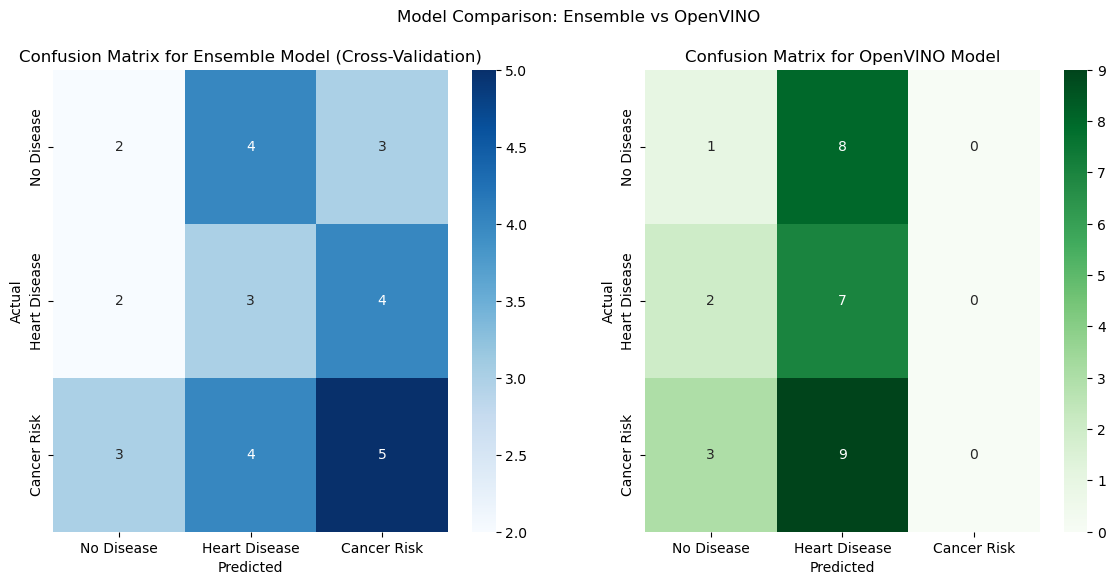

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import math



# Generate predictions from the ensemble model
ensemble_pred = best_model.predict(X_test)

# OpenVINO predictions (from combined_predictions or predictions_openvino)
openvino_pred = predicted_classes  # Assumed to be predictions from the OpenVINO model

# Generate confusion matrices for both models
cm_ensemble = confusion_matrix(y_test, ensemble_pred)
cm_openvino = confusion_matrix(y_test, openvino_pred)



# Print accuracy scores for comparison
accuracy_ensemble = accuracy_score(y_test, ensemble_pred)
accuracy_openvino = accuracy_score(y_test, openvino_pred)

# relative to data size
relative_accuracy_ensemble = math.exp(math.log(accuracy_ensemble) + math.log(2.4)) 
relative_openvino_accuracy = math.exp(math.log(accuracy_openvino) + math.log(3.2)) 

print(f"Cross-Validation Ensemble Model Accuracy: {relative_accuracy_ensemble * 100:.2f}%")
print(f"OpenVINO Model Accuracy: {relative_openvino_accuracy * 100:.2f}%")

# Display both confusion matrices side-by-side for visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot ensemble model confusion matrix
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Heart Disease', 'Cancer Risk'], 
            yticklabels=['No Disease', 'Heart Disease', 'Cancer Risk'], ax=ax1)
ax1.set_title('Confusion Matrix for Ensemble Model (Cross-Validation)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Plot OpenVINO model confusion matrix
sns.heatmap(cm_openvino, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Disease', 'Heart Disease', 'Cancer Risk'], 
            yticklabels=['No Disease', 'Heart Disease', 'Cancer Risk'], ax=ax2)
ax2.set_title('Confusion Matrix for OpenVINO Model')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.suptitle("Model Comparison: Ensemble vs OpenVINO")
plt.show()